# VQE Implementation in Qiskit for LiH 

In [6]:
import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

qiskit_nature.settings.use_pauli_sum_op = False
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import SPSA, SLSQP, COBYLA

In [7]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["Li", "H"],
        coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [8]:
from qiskit_aer.primitives import Estimator


def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.04791 Exact Energy: -7.04791
Interatomic Distance: 0.7 VQE Result: -7.50400 Exact Energy: -7.50400
Interatomic Distance: 0.9 VQE Result: -7.72283 Exact Energy: -7.72283
Interatomic Distance: 1.1 VQE Result: -7.82520 Exact Energy: -7.82520
Interatomic Distance: 1.3 VQE Result: -7.86890 Exact Energy: -7.86890
Interatomic Distance: 1.5 VQE Result: -7.88214 Exact Energy: -7.88214
Interatomic Distance: 1.7 VQE Result: -7.87920 Exact Energy: -7.87920
Interatomic Distance: 1.9 VQE Result: -7.86799 Exact Energy: -7.86799
Interatomic Distance: 2.1 VQE Result: -7.85320 Exact Energy: -7.85320
Interatomic Distance: 2.3 VQE Result: -7.83772 Exact Energy: -7.83772
Interatomic Distance: 2.5 VQE Result: -7.82343 Exact Energy: -7.82343
Interatomic Distance: 2.7 VQE Result: -7.81142 Exact Energy: -7.81142
Interatomic Distance: 2.9 VQE Result: -7.80215 Exact Energy: -7.80215
Interatomic Distance: 3.1 VQE Result: -7.79545 Exact Energy: -7.79545
Interatomic Distance

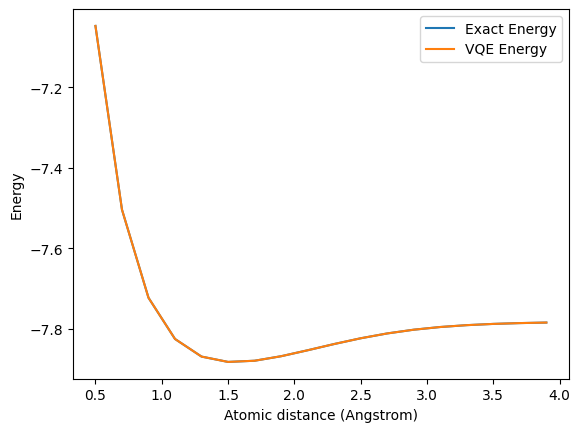

In [9]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

# Running VQE on a Noisy Simulator for H2

In [11]:
molecule = MoleculeInfo(
    # Coordinates in Angstrom
    symbols=["H", "H"],
    coords=([0.0, 0.0, -0.3625], [0.0, 0.0, 0.3625]),
    multiplicity=1,
    charge=0,
)

driver = PySCFDriver.from_molecule(molecule)
problem = driver.run()

second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

mapper = ParityMapper(num_particles=num_particles)  # Set Mapper

hamiltonian = second_q_ops[0]  # Set Hamiltonian

# Do two qubit reduction
qubit_op = mapper.map(hamiltonian)

In [13]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

# fake providers contain data from real IBM Quantum devices stored
# in Qiskit Terra, and are useful for extracting realistic noise models.

device = FakeVigo()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
noisy_estimator = Estimator(
    backend_options={"coupling_map": coupling_map, "noise_model": noise_model}
)

In [14]:
result = exact_solver(qubit_op, problem)
exact_energies.append(result.total_energies)

print("Exact Result:", result.total_energies)
optimizer = SPSA(maxiter=100)
var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
vqe = VQE(noisy_estimator, var_form, optimizer)
vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
vqe_result = problem.interpret(vqe_calc).total_energies
print("VQE Result:", vqe_result)

Exact Result: [-1.13722138]
VQE Result: [-1.04256142]
